# Clustering de textes
Regrouper des textes

In [1]:
# Import
from random import sample
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# import spacy
# import datetime as dt
# from collections import Counter
# import seaborn as sns

In [2]:
# Import data
data_path = "../data/"
df = pd.read_pickle(data_path+"df_2017_avec_auteurs.pkl")

In [3]:
# Choix du corpus
dfh = df[df.rubrique.apply(lambda x : x in set(df.rubrique.head(5)))]
corpus = dfh.question
len(corpus)

1158

In [4]:
# Rubriques correspondantes sous forme d'entier
l_r = list(dfh.rubrique.unique())
dic_r = {l_r[i] : i for i in range(len(l_r))}
rubint = dfh.rubrique.apply(lambda x : dic_r[x])

In [5]:
# Groupes correspondants sous forme d'entier
l_g = list(dfh.groupe_auteur.unique())
dic_g = {l_g[i] : i for i in range(len(l_g))}
groupint = dfh.groupe_auteur.apply(lambda x : dic_g[x])


## A. Préparation
### A.1 TF et TFIDF

In [6]:
from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

stop_words = get_stop_words('french')

# Calcul du TF-IF (pour brut, lsa, nmf ...)
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Calcul du TF (pour LDA)
tf_vectorizer = CountVectorizer(stop_words=stop_words)
tf = tf_vectorizer.fit_transform(corpus)
tf_feature_names = tf_vectorizer.get_feature_names()

# Show part of result
samp = sample(range(len(tfidf_feature_names)),15)
docsamp = np.array([v[samp] for v in tfidf.toarray() if sum(v[samp])>0.0])
pd.DataFrame(docsamp,columns = np.array(tfidf_feature_names)[samp]).head(5)

,crible,semer,normandie,curable,via,automne,maximiser,research,compliqué,fiabilité,rénovation,inexistence,détecter,29èm,éventuel
0,0.0,0.0,0.0,0.0,0.103523,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.092735,0.0,0.0,0.00000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.118821,0.0,0.0,0.00000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.11021,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.04373,0.0,0.0


### A.2 ACP sur le TF-IDF

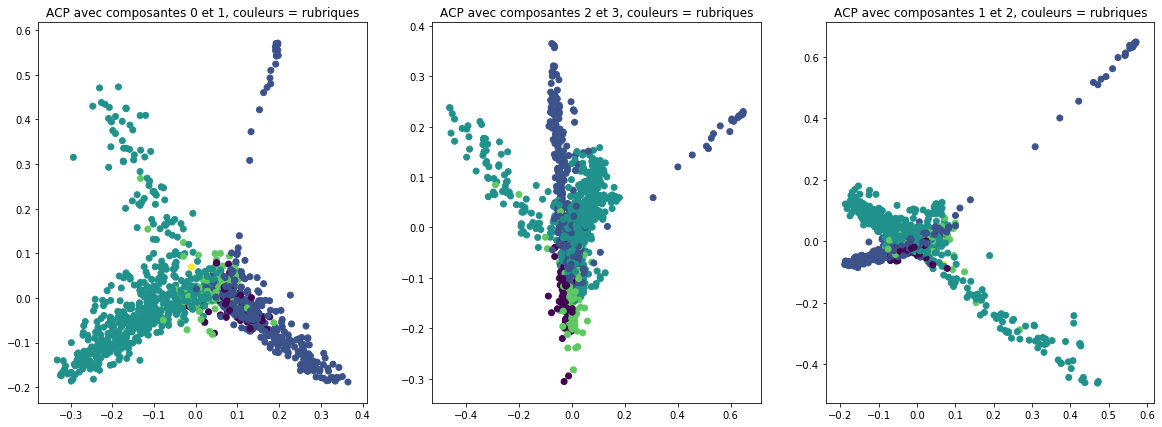

In [7]:
# reduce the features to 2D
from sklearn.decomposition import PCA

# Avec 4 principaux
random_state = 0
pca_tfidf = PCA(n_components=4, random_state=random_state)
reduced_features_tfidf = pca_tfidf.fit_transform(tfidf.toarray())
fig, axes = plt.subplots(1,3,figsize = (20,7))
axes[0].scatter(reduced_features_tfidf[:,0], reduced_features_tfidf[:,1], c=rubint)
axes[0].set_title("ACP avec composantes {} et {}, couleurs = rubriques".format(0,1))
axes[1].scatter(reduced_features_tfidf[:,2], reduced_features_tfidf[:,3], c=rubint)
axes[1].set_title("ACP avec composantes {} et {}, couleurs = rubriques".format(2,3))
axes[2].scatter(reduced_features_tfidf[:,1], reduced_features_tfidf[:,2], c=rubint)
axes[2].set_title("ACP avec composantes {} et {}, couleurs = rubriques".format(1,2));

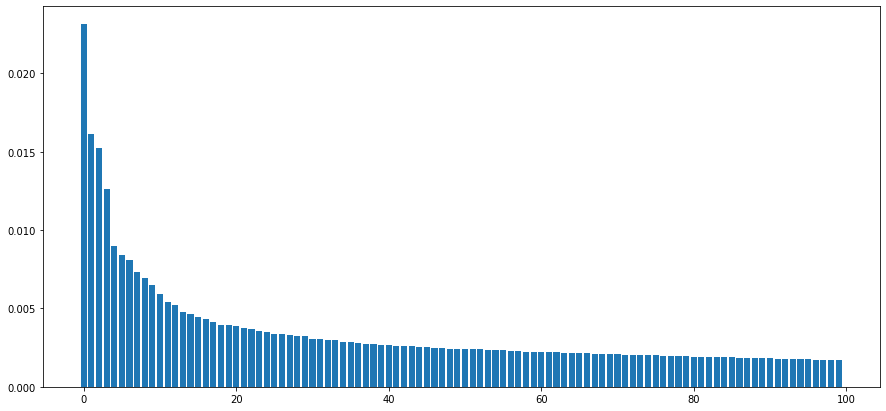

In [8]:
# Explained variance 
nmax = 100
pca_tfidf = PCA(n_components=nmax, random_state=random_state)
pca_tfidf.fit_transform(tfidf.toarray())
plt.figure(figsize = (15,7))
plt.bar(range(nmax),pca_tfidf.explained_variance_ratio_);

## B. Brut : Clustering en s'apuyant sur la matrice des tf-idf ou des occurrences directement

In [9]:
ALL_CLUSTERS = pd.DataFrame(columns = ['vector_type','opt_vector','clustering_method','opt_clust','clusters'])
def add_to_ALL(args):
    ip =  ALL_CLUSTERS.index.max()+1
    if len(ALL_CLUSTERS) == 0:
        ip = 0
    ALL_CLUSTERS.loc[ip] = args

In [10]:
def delete_last_ALL():
    idxlast = ALL_CLUSTERS.index.max()
    ALL_CLUSTERS.drop(idxlast,inplace = True)

## B.1 k-means
Prendre un corpus de documents, vectoriser avec tf idf, kmeans dessus. 
* From https://sanjayasubedi.com.np/nlp/nlp-with-python-document-clustering/
* Voir https://scikit-learn.org/stable/modules/clustering.html pour clustering on python

### B.1.1 Calcul du k-means

In [11]:
# Scores de clustering
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

In [12]:
from sklearn.cluster import MiniBatchKMeans

# Exécution du k-means
random_state = 0
k_kmeans_tfidf = 10
kmeans_tfidf = MiniBatchKMeans(n_clusters=k_kmeans_tfidf, random_state=random_state)
kmeans_tfidf.fit(tfidf);
tfidf_kmeans_clusters = kmeans_tfidf.predict(tfidf)
add_to_ALL(['tfidf',None,'kmeans',k_kmeans_tfidf,tfidf_kmeans_clusters])

# Calcul des scores
print('Inertie = {:.2f}, Calisnki-Harabasz = {:.2f}, Davies-Bouldin = {:.2f}'.format(
    kmeans_tfidf.inertia_,
    calinski_harabasz_score(tfidf.toarray(),tfidf_kmeans_clusters),
    davies_bouldin_score(tfidf.toarray(),tfidf_kmeans_clusters)))


Inertie = 1025.92, Calisnki-Harabasz = 10.19, Davies-Bouldin = 5.43


### B.1.2 ACP des centres et affichage

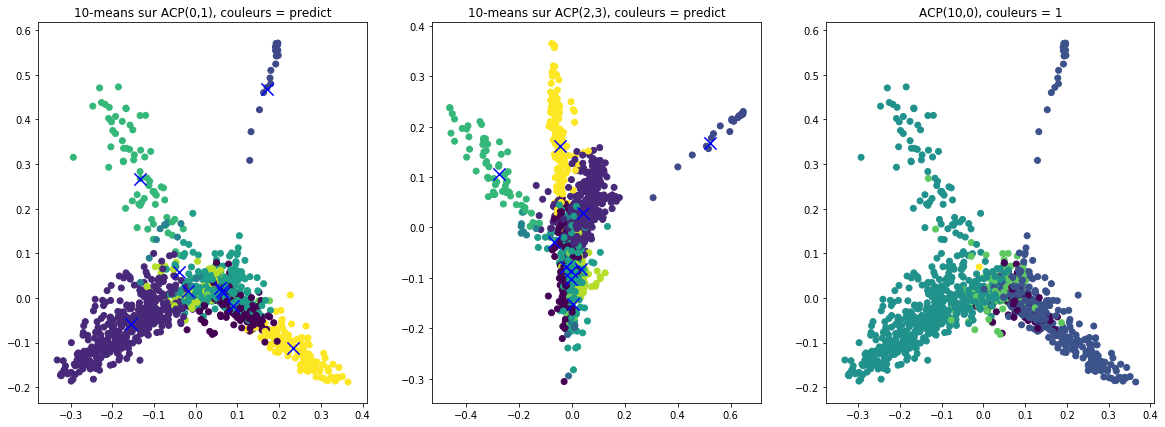

In [13]:
reduced_cluster_centers_tfidf = pca_tfidf.transform(kmeans_tfidf.cluster_centers_)
fig, axes = plt.subplots(1,3,figsize = (20,7))
axes[0].scatter(reduced_features_tfidf[:,0], reduced_features_tfidf[:,1], c=tfidf_kmeans_clusters)
axes[0].scatter(reduced_cluster_centers_tfidf[:, 0], reduced_cluster_centers_tfidf[:,1], marker='x', s=150, c='b')
axes[0].set_title('{}-means sur ACP({},{}), couleurs = {}'.format(k_kmeans_tfidf,0,1,'predict'))
axes[1].scatter(reduced_features_tfidf[:,2], reduced_features_tfidf[:,3], c=kmeans_tfidf.predict(tfidf))
axes[1].scatter(reduced_cluster_centers_tfidf[:, 2], reduced_cluster_centers_tfidf[:,3], marker='x', s=150, c='b')
axes[1].set_title('{}-means sur ACP({},{}), couleurs = {}'.format(k_kmeans_tfidf,2,3,'predict'))
axes[2].scatter(reduced_features_tfidf[:,0], reduced_features_tfidf[:,1], c=rubint);
axes[2].set_title('ACP({},{}), couleurs = {}'.format(k_kmeans_tfidf,0,1,'rubriques'));

## B.2 Ward HAC
https://chrisalbon.com/machine_learning/clustering/agglomerative_clustering/

### B.2.1 Clustering hac

In [14]:
# Create meanshift object
from sklearn.cluster import AgglomerativeClustering
linkage_hac_tfidf = 'complete'
affinity_hac_tfidf ='cosine'
aggc_tfidf = AgglomerativeClustering(linkage=linkage_hac_tfidf, 
                              affinity=affinity_hac_tfidf, 
                              n_clusters=5)

# Train model
aggc_tfidf = aggc_tfidf.fit(tfidf.toarray())
aggc_tfidf_clusters = aggc_tfidf.labels_
add_to_ALL(['tfidf',None,'aggc',[linkage_hac_tfidf,affinity_hac_tfidf],aggc_tfidf_clusters])

# Calcul des scores
print('Calisnki-Harabasz = {:.2f}, Davies-Bouldin = {:.2f}'.format(
    calinski_harabasz_score(tfidf.toarray(),aggc_tfidf_clusters),
    davies_bouldin_score(tfidf.toarray(),aggc_tfidf_clusters)))

Calisnki-Harabasz = 8.27, Davies-Bouldin = 8.04


### B.2.2 ACP et affichage

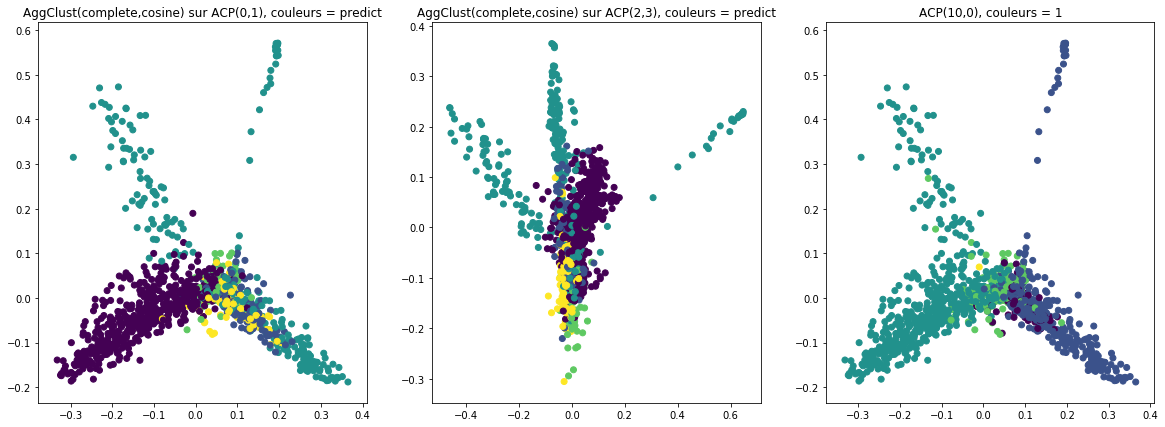

In [15]:
fig, axes = plt.subplots(1,3,figsize = (20,7))
axes[0].scatter(reduced_features_tfidf[:,0], reduced_features_tfidf[:,1], c=aggc_tfidf_clusters)
axes[0].set_title('AggClust({},{}) sur ACP({},{}), couleurs = {}'.format(linkage_hac_tfidf,affinity_hac_tfidf,0,1,'predict'))
axes[1].scatter(reduced_features_tfidf[:,2], reduced_features_tfidf[:,3], c=aggc_tfidf_clusters)
axes[1].set_title('AggClust({},{}) sur ACP({},{}), couleurs = {}'.format(linkage_hac_tfidf,affinity_hac_tfidf,2,3,'predict'))
axes[2].scatter(reduced_features_tfidf[:,0], reduced_features_tfidf[:,1], c=rubint)
axes[2].set_title('ACP({},{}), couleurs = {}'.format(k_kmeans_tfidf,0,1,'rubriques'));

### B.2.Résultats, questions et suggestions
* Euclidian et complete : même résultat que k-means, assez agréable à la vue
* Euclidean et single, 5 : très bof quelques points différents au centre mais reste du meme cluster, pour dimensions 1, 2, 3 et 4
* Euclidean et ward, 5 : pas mal 
* Cosine : single et average, 5 et 20 très bof comme euclidean et single. Complete mieux pour 5 et 20 mais reste étrange (plusieurs branches de même couleur et chaos au milieu)

In [16]:
# Dendogramme associé https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html?highlight=linkage#scipy.cluster.hierarchy.linkage
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(tfidf.toarray(),metric='euclidean',method = 'single');

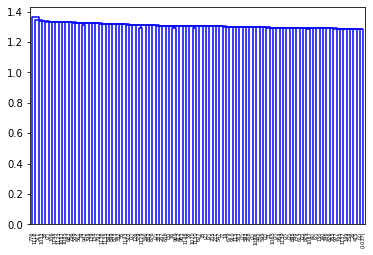

In [17]:
dendrogram(Z,p=100,truncate_mode = 'lastp');

### B.2. Remarques
* Dendogramme toujours illisible en troncaté car les points arrrivent petit à petit

# B.3 X-Means
* Article original : https://www.cs.cmu.edu/~dpelleg/download/xmeans.pdf 
* pyclustering : https://pyclustering.github.io/docs/0.9.3/html/dd/db4/classpyclustering_1_1cluster_1_1xmeans_1_1xmeans.html

In [18]:
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster import cluster_visualizer

# X-means function
def execute_xmeans(vecs,kmin,kmax):
    amount_initial_centers = kmin
    initial_centers = kmeans_plusplus_initializer(vecs, amount_initial_centers).initialize()

    xmeans_instance = xmeans(vecs, initial_centers, kmax)
    xmeans_instance.process()

    return xmeans_instance

# Execution
xmin_tfidf,xmax_tfidf = 2,30
xmeans_tfidf = execute_xmeans(tfidf.toarray(),xmin_tfidf,xmax_tfidf)
xmeans_tfidf_clusters_grouped = xmeans_tfidf.get_clusters()
xmeans_tfidf_clusters = pd.Series({j : i for i,m in enumerate(xmeans_tfidf_clusters_grouped) for j in m}).sort_index().values
xmeans_tfidf_centers = xmeans_tfidf.get_centers()
xmeans_tfidf_nb_clusters = len(xmeans_tfidf_clusters_grouped)
add_to_ALL(['tfidf',None,'xmeans',[xmin_tfidf,xmax_tfidf],xmeans_tfidf_clusters])

# Scores
print("Nb clusters = {}, WCE = {:.2f},Calisnki-Harabasz = {:.2f}, Davies-Bouldin = {:.2f}".format(
    xmeans_tfidf_nb_clusters,
    xmeans_tfidf.get_total_wce(),
    calinski_harabasz_score(tfidf.toarray(),xmeans_tfidf_clusters),
    davies_bouldin_score(tfidf.toarray(),xmeans_tfidf_clusters)))

Nb clusters = 2, WCE = 1086.34,Calisnki-Harabasz = 20.28, Davies-Bouldin = 7.55


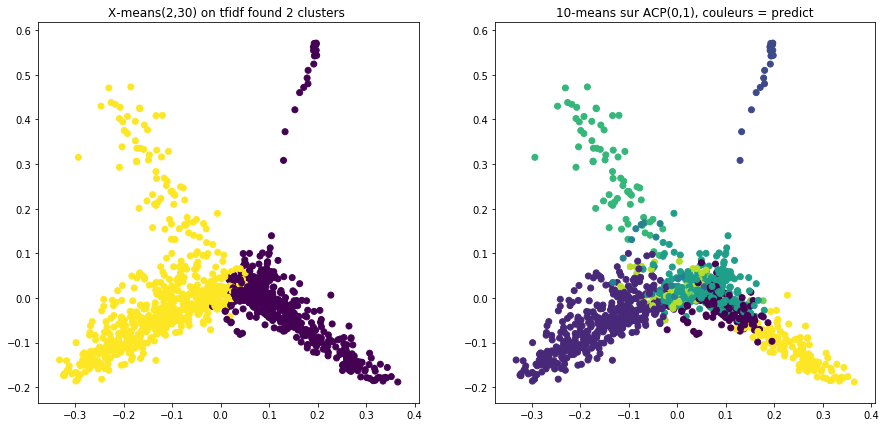

In [19]:
# Affichage
fig,axes = plt.subplots(1,2,figsize = (15,7))
axes[0].scatter(reduced_features_tfidf[:,0], reduced_features_tfidf[:,1], c=xmeans_tfidf_clusters)
axes[0].set_title('X-means({},{}) on {} found {} clusters '.format(xmin_tfidf,xmax_tfidf,'tfidf',xmeans_tfidf_nb_clusters));
axes[1].scatter(reduced_features_tfidf[:,0], reduced_features_tfidf[:,1], c=kmeans_tfidf.predict(tfidf))
axes[1].set_title('{}-means sur ACP({},{}), couleurs = {}'.format(k_kmeans_tfidf,0,1,'predict'));

### B.3.résultats, questions et suggestions
* Reste sur le nombre de custers minimal (5,10,20)
* Tester X-means sur les autres machins de vecteurs

# C. Clustering avec décompositions de matrices
## C.3 Ananlyse Sémantique Latente LSA

### C.3.1 Décomposition en valeurs singulières

In [20]:
from sklearn.decomposition import TruncatedSVD

dim_lsa = 10 # Pas bon du tout, tenter de voir les meilleures valeurs singulières
svd_model = TruncatedSVD(n_components=dim_lsa, algorithm='randomized', n_iter=100, random_state=122)
lsa_doc_vectors = svd_model.fit_transform(tfidf)

In [94]:
lsa_word_vectors = svd_model.fit(tfidf).components_

### C.3.2 Affichage des topics repérés

In [104]:
for i, comp in enumerate(lsa_word_vectors):
    terms_comp = zip(tfidf_feature_names, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ",end= ' ')
    for t in sorted_terms:
        print(t[0],end=' ')
    print('')

Topic 0:  maladie santé charge prise cancer patient pouvoir 
Topic 1:  service carte ant gris titre usager préfecture 
Topic 2:  cancer école enfant euro million pédiatrique compte 
Topic 3:  école compte administration million euro impayer maladie 
Topic 4:  social français étranger sécurité régime cotisation fraude 
Topic 5:  lyme tique test dépistage diagnostic protocole plan 
Topic 6:  alzheimer plan maladie enfant financement million pmnd 
Topic 7:  diabète diabétique métier alzheimer type accès atteindre 
Topic 8:  français étranger france diabète consulaire diabétique permettre 
Topic 9:  fibromyalgie alzheimer dépistage colorectal france femme trouble 


### C.3.3 Clustering et affichage (umap et acp)

In [22]:
# K-means
k_kmeans_lsa = 10
kmeans_lsa = MiniBatchKMeans(n_clusters=k_kmeans_lsa, random_state=random_state)
kmeans_lsa.fit(lsa_doc_vectors);
lsa_kmeans_clusters = kmeans_lsa.predict(lsa_doc_vectors)

# Calcul des scores
print('Inertie = {:.2f}, Calisnki-Harabasz = {:.2f}, Davies-Bouldin = {:.2f}'.format(
    kmeans_lsa.inertia_,
    calinski_harabasz_score(lsa_doc_vectors,lsa_kmeans_clusters),
    davies_bouldin_score(lsa_doc_vectors,lsa_kmeans_clusters)))

Inertie = 30.02, Calisnki-Harabasz = 393.27, Davies-Bouldin = 0.85


In [23]:
# Execution X-means
xmin_lsa,xmax_lsa = 10,30
lsa_xmeans = execute_xmeans(lsa_doc_vectors,xmin_lsa,xmax_lsa)
lsa_xmeans_clusters_grouped = lsa_xmeans.get_clusters()
lsa_xmeans_clusters = pd.Series({j : i for i,m in enumerate(lsa_xmeans_clusters_grouped) for j in m}).sort_index().values
lsa_xmeans_centers = lsa_xmeans.get_centers()
lsa_xmeans_nb_clusters = len(lsa_xmeans_clusters_grouped)

add_to_ALL(['lsa',None,'xmeans',[xmin_lsa,xmax_lsa],lsa_xmeans_clusters])

# Scores
print("Nb clusters = {}, WCE = {:.2f},Calisnki-Harabasz = {:.2f}, Davies-Bouldin = {:.2f}".format(
    lsa_xmeans_nb_clusters,
    lsa_xmeans.get_total_wce(),
    calinski_harabasz_score(lsa_doc_vectors,lsa_xmeans_clusters),
    davies_bouldin_score(lsa_doc_vectors,lsa_xmeans_clusters)))

Nb clusters = 30, WCE = 12.85,Calisnki-Harabasz = 325.56, Davies-Bouldin = 0.87


In [24]:
# UMAP https://umap-learn.readthedocs.io/en/latest/
from umap import UMAP
embedding_lsa = UMAP(n_neighbors=100, min_dist=0.5, random_state=12).fit_transform(lsa_doc_vectors)

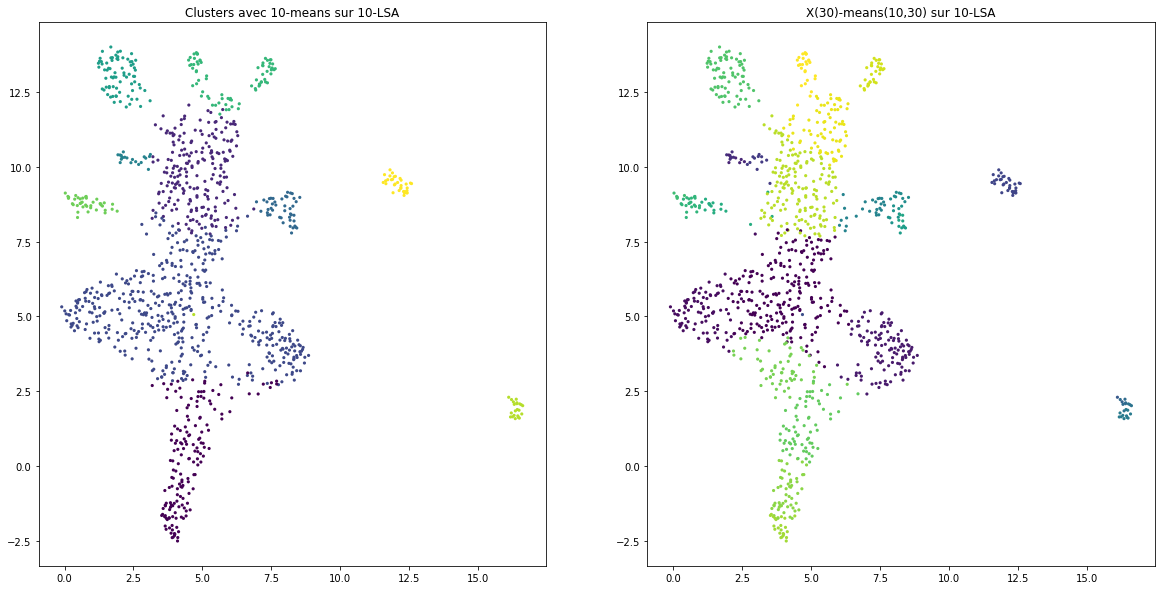

In [25]:
fig,axes = plt.subplots(1,2,figsize=(20,10))
axes[0].scatter(embedding_lsa[:, 0], embedding_lsa[:, 1], 
    c = lsa_kmeans_clusters,
    s = 10, # size
    edgecolor='none')
axes[0].set_title("Clusters avec {}-means sur {}-LSA".format(k_kmeans_lsa,dim_lsa));
# axes[1].scatter(embedding[:, 0], embedding[:, 1], 
#     c = rubint,
#     s = 10, # size
#     edgecolor='none')
# axes[1].set_title("Rubriques sur répartition {}-LSA".format(dim_lsa));
axes[1].scatter(embedding_lsa[:, 0], embedding_lsa[:, 1], 
    c = lsa_xmeans_clusters,
    s = 10, # size
    edgecolor='none')
axes[1].set_title("X({})-means({},{}) sur {}-LSA".format(lsa_xmeans_nb_clusters,xmin_lsa,xmax_lsa,dim_lsa));

In [26]:
# ACP
# reduce the features to 2D
from sklearn.decomposition import PCA
pca_lsa = PCA(n_components=2, random_state=random_state)
reduced_features_lsa = pca_lsa.fit_transform(lsa_doc_vectors)

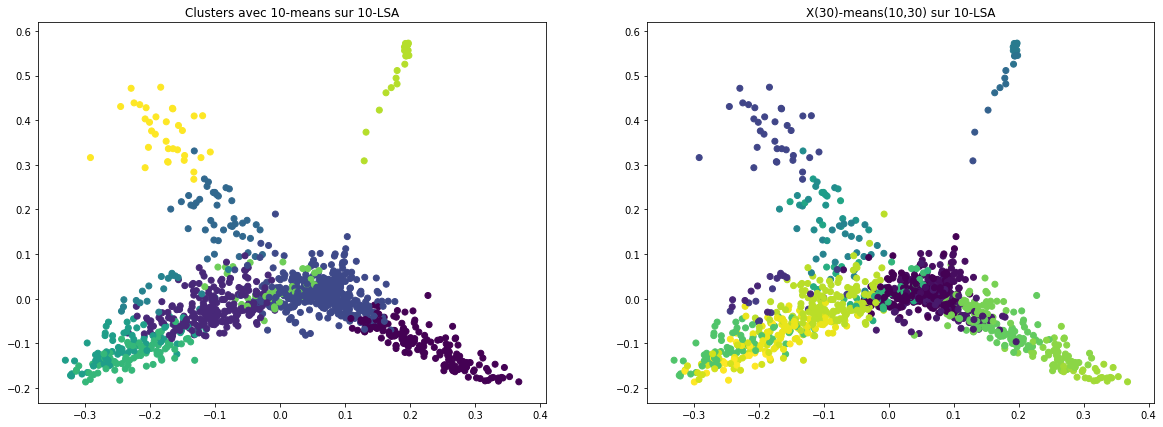

In [27]:
fig, axes = plt.subplots(1,2,figsize = (20,7))
axes[0].scatter(reduced_features_lsa[:,0], reduced_features_lsa[:,1], c=lsa_kmeans_clusters)
axes[1].scatter(reduced_features_lsa[:,0], reduced_features_lsa[:,1], c=lsa_xmeans_clusters)
axes[0].set_title("Clusters avec {}-means sur {}-LSA".format(k_kmeans_lsa,dim_lsa));
axes[1].set_title("X({})-means({},{}) sur {}-LSA".format(lsa_xmeans_nb_clusters,xmin_lsa,xmax_lsa,dim_lsa));

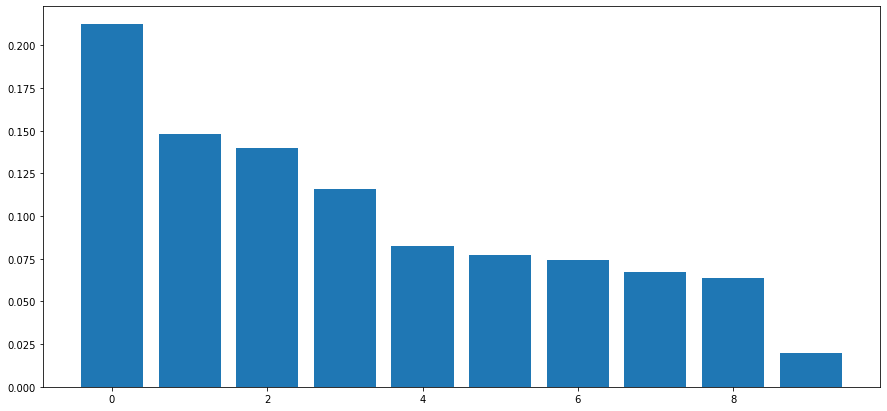

In [28]:
# Explained variance 
nmax = dim_lsa
pca_lsa = PCA(n_components=nmax, random_state=random_state)
pca_lsa.fit_transform(lsa_doc_vectors)
plt.figure(figsize = (15,7))
plt.bar(range(nmax),pca_lsa.explained_variance_ratio_);

euclidean, complete ...  ok 
euclidean, single ...  ok 
euclidean, average ...  ok 
cosine, complete ...  ok 
cosine, single ...  ok 
cosine, average ...  ok 


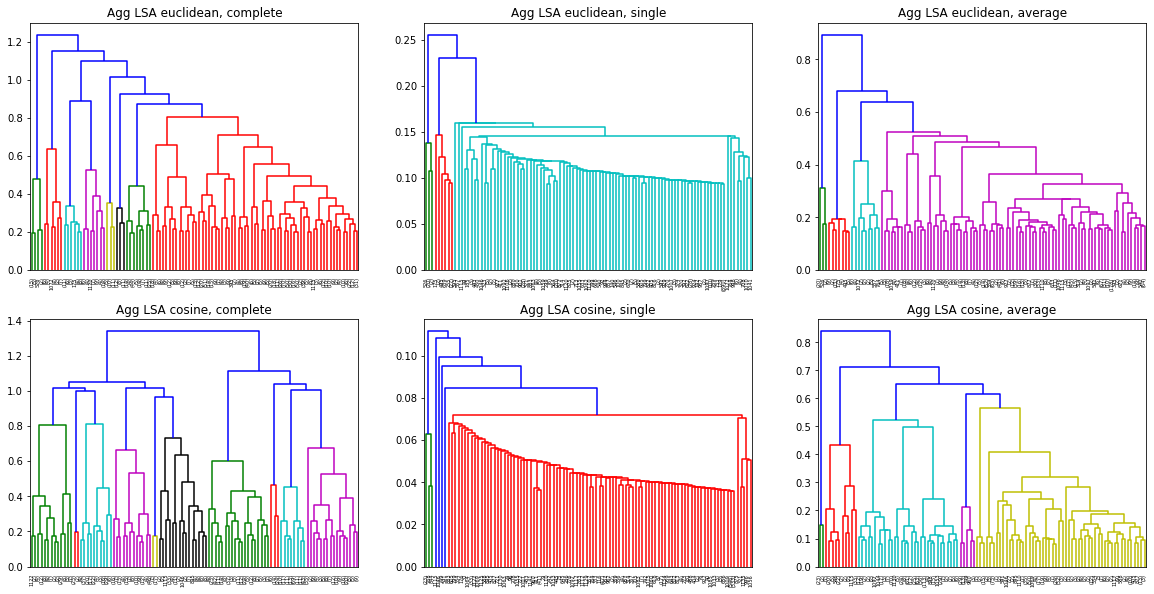

In [29]:
metrics = ['euclidean','cosine']
methods = ['complete','single','average']
fig,axes = plt.subplots(len(metrics),len(methods),figsize = (20,10))
for ic,metric in enumerate(metrics):
    for ih,method in enumerate(methods):
        print("{}, {} ...".format(metric,method),end = ' ')
        Z_lsa = linkage(lsa_doc_vectors,metric=metric,method = method);
        dendrogram(Z_lsa,p=100,truncate_mode = 'lastp',ax = axes[ic,ih])
        axes[ic,ih].set_title('Agg LSA {}, {}'.format(metric, method))
        print(' ok ')

## C.4 Allocation de Dirichlet Latente et Factorisation de Matrices non-Négatives
https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
### C.4.1 Topic modelling avec nmf et lda

In [30]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic {}".format(topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
no_features = len(corpus)

n_topics_nmf = 10
n_topics_lda = 10

# Run NMF
nmf_topics = NMF(n_components=n_topics_nmf, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda_topics = LatentDirichletAllocation(n_components=n_topics_lda, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10
print("\n------------------ TOPICS NMF --------------------\n")
display_topics(nmf_topics, tfidf_feature_names, no_top_words)
print("\n------------------ TOPICS LDA --------------------\n")
display_topics(lda_topics, tf_feature_names, no_top_words)


------------------ TOPICS NMF --------------------

Topic 0
maladie charge prise patient santé tarlov rare atteindre douleur affection
Topic 1
carte gris ant titre service préfecture usager délai site demande
Topic 2
école compte administration euro million impayer enseigner facture denier redressement
Topic 3
cancer enfant pédiatrique recherche dépistage financement 500 décès an pourcent
Topic 4
social sécurité fraude public cotisation régime service article travail compte
Topic 5
lyme maladie tique test diagnostic santé protocole patient plan pnds
Topic 6
alzheimer maladie plan million pmnd apparenter neurodégénératif aidant 2014 atteindre
Topic 7
diabète diabétique métier type accès armée condition discrimination réglementation certain
Topic 8
français étranger france consulaire établir résider pays pouvoir europe affaire
Topic 9
fibromyalgie reconnaissance reconnaître maladie recommandation prise officiellement douleur entier charge

------------------ TOPICS LDA -----------------

### C.4.2 Clustering LDA

In [31]:
# LDA for doc vectors
lda_doc_model = LatentDirichletAllocation(n_components=n_topics_lda, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf.T)
lda_doc_vectors = lda_doc_model.components_.T

In [32]:
# GENSIM, résultat différent
# Fabrication du modèle LDA à partir des occurences des mots
# from gensim import corpora, models, similarities 
# n_topics_lda = 5
# final_doc = corpus.apply(lambda x : x.split(' '))
# dictionary = corpora.Dictionary(final_doc)

# DT_matrix = [dictionary.doc2bow(doc) for doc in final_doc]
# %time lda = models.LdaModel(DT_matrix,id2word=dictionary,num_topics=n_topics_lda)

In [33]:
# Convertion en vecteur de sujets par document
# def to_vec(bow,k):
#     vec = np.zeros(k)
#     for i,v in bow:
#         vec[i] = v
#     return vec

# lda_gensim_doc_values = np.array([to_vec(lda.get_document_topics(DT_matrix[i]),n_topics_lda) for i in range(len(corpus))])

In [34]:
# K-means LDA
k_kmeans_lda = 10
kmeans_lda = MiniBatchKMeans(n_clusters=k_kmeans_lda, random_state=random_state)
kmeans_lda.fit(lda_doc_vectors);
lda_kmeans_clusters = kmeans_lda.predict(lda_doc_vectors)
# Calcul des scores
print('Inertie = {:.2f}, Calisnki-Harabasz = {:.2f}, Davies-Bouldin = {:.2f}'.format(
    kmeans_lda.inertia_,
    calinski_harabasz_score(lda_doc_vectors,lda_kmeans_clusters),
    davies_bouldin_score(lda_doc_vectors,lda_kmeans_clusters)))

Inertie = 4377257.13, Calisnki-Harabasz = 220.13, Davies-Bouldin = 1.09


In [35]:
# Execution X-means LDA
xmin_lda,xmax_lda = 10,50
lda_xmeans = execute_xmeans(lda_doc_vectors,xmin_lda,xmax_lda)
lda_xmeans_clusters_grouped = lda_xmeans.get_clusters()
lda_xmeans_clusters = pd.Series({j : i for i,m in enumerate(lda_xmeans_clusters_grouped) for j in m}).sort_index().values
lda_xmeans_centers = lda_xmeans.get_centers()
lda_xmeans_nb_clusters = len(lda_xmeans_clusters_grouped)

# Scores LDA
print("Nb clusters = {}, WCE = {:.2f},Calisnki-Harabasz = {:.2f}, Davies-Bouldin = {:.2f}".format(
    lda_xmeans_nb_clusters,
    lda_xmeans.get_total_wce(),
    calinski_harabasz_score(lda_doc_vectors,lda_xmeans_clusters),
    davies_bouldin_score(lda_doc_vectors,lda_xmeans_clusters)))

Nb clusters = 43, WCE = 1312940.39,Calisnki-Harabasz = 209.84, Davies-Bouldin = 0.70


In [36]:
# ACP LDA
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=random_state)
reduced_features_lda = pca.fit_transform(lda_doc_vectors)

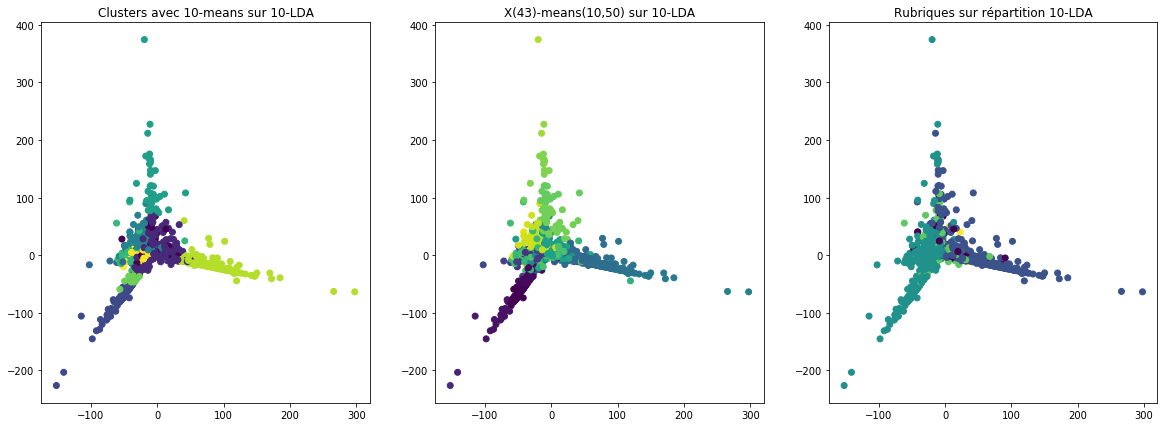

In [37]:
# Affichage ACP LDA
fig, axes = plt.subplots(1,3,figsize = (20,7))
axes[0].scatter(reduced_features_lda[:,0], reduced_features_lda[:,1], c=lda_kmeans_clusters)
axes[1].scatter(reduced_features_lda[:,0], reduced_features_lda[:,1], c=lda_xmeans_clusters)
axes[2].scatter(reduced_features_lda[:,0], reduced_features_lda[:,1], c=rubint)
axes[0].set_title("Clusters avec {}-means sur {}-LDA".format(k_kmeans_lda,n_topics_lda));
axes[1].set_title("X({})-means({},{}) sur {}-LDA".format(lda_xmeans_nb_clusters,xmin_lda,xmax_lda,n_topics_lda));
axes[2].set_title("Rubriques sur répartition {}-LDA".format(n_topics_lda));

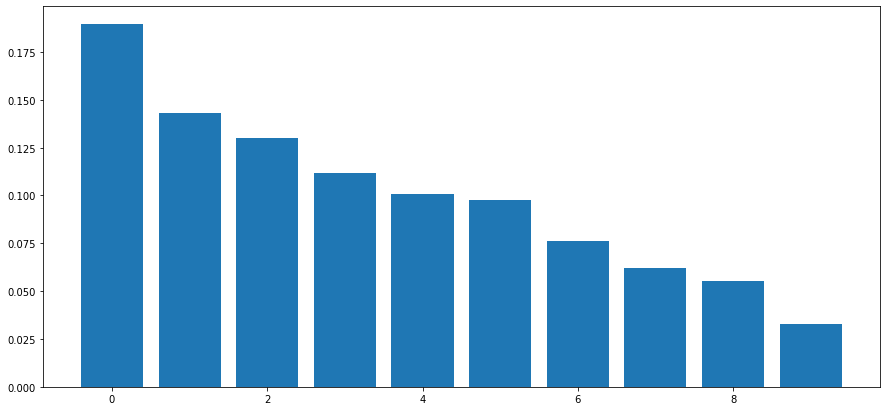

In [38]:
# Explained variance 
nmax = n_topics_lda
pca_lda = PCA(n_components=nmax, random_state=random_state)
pca_lda.fit_transform(lda_doc_vectors)
plt.figure(figsize = (15,7))
plt.bar(range(nmax),pca_lda.explained_variance_ratio_);

In [39]:
from umap import UMAP
embedding_lda = UMAP(n_neighbors=100, min_dist=0.5, random_state=12).fit_transform(lda_doc_vectors)

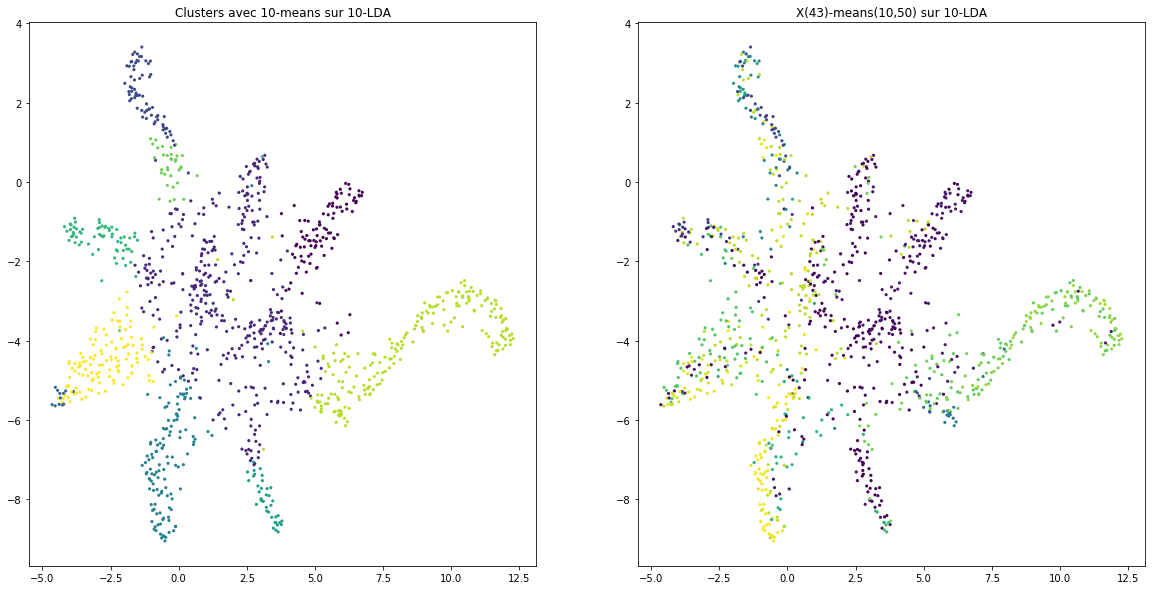

In [40]:
# Affichage umap LDA
fig,axes = plt.subplots(1,2,figsize=(20,10))
axes[0].scatter(embedding_lda[:, 0], embedding_lda[:, 1], 
    c = lda_kmeans_clusters,
    s = 10, # size
    edgecolor='none')
axes[0].set_title("Clusters avec {}-means sur {}-LDA".format(k_kmeans_lda,n_topics_lda));
# axes[1].scatter(embedding[:, 0], embedding[:, 1], 
#     c = rubint,
#     s = 10, # size
#     edgecolor='none')
axes[1].scatter(embedding_lda[:, 0], embedding_lda[:, 1], 
    c = lsa_xmeans_clusters,
    s = 10, # size
    edgecolor='none')
axes[1].set_title("X({})-means({},{}) sur {}-LDA".format(lda_xmeans_nb_clusters,xmin_lda,xmax_lda,n_topics_lda));

euclidean, complete ...  ok 
euclidean, single ...  ok 
euclidean, average ...  ok 
cosine, complete ...  ok 
cosine, single ...  ok 
cosine, average ...  ok 


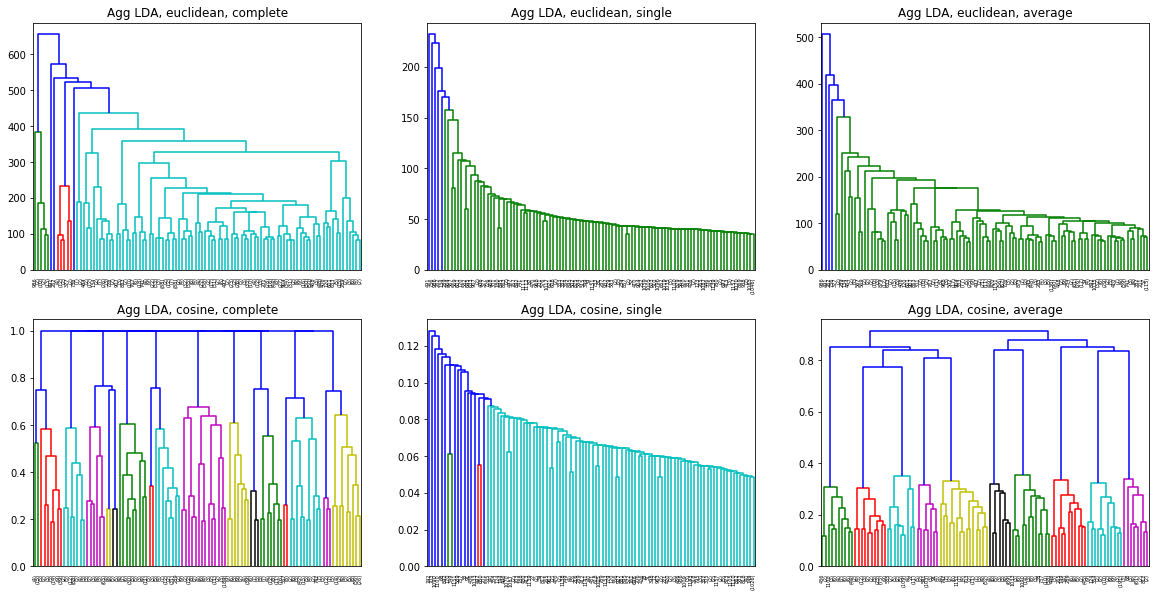

In [41]:
metrics = ['euclidean','cosine']
methods = ['complete','single','average']
fig,axes = plt.subplots(len(metrics),len(methods),figsize = (20,10))
for ic,metric in enumerate(metrics):
    for ih,method in enumerate(methods):
        print("{}, {} ...".format(metric,method),end = ' ')
        Z_lda = linkage(lda_doc_vectors,metric=metric,method = method);
        dendrogram(Z_lda,p=100,truncate_mode = 'lastp',ax = axes[ic,ih])
        axes[ic,ih].set_title('Agg LDA, {}, {}'.format(metric, method))
        print(' ok ')

### C.4.3 Clustering NMF

In [42]:
# NMF for doc vectors
nmf_doc_model = NMF(n_components=n_topics_nmf, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf.T)
nmf_doc_vectors = nmf_doc_model.components_.T

In [43]:
# K-means nmf
k_kmeans_nmf = 10
kmeans_nmf = MiniBatchKMeans(n_clusters=k_kmeans_nmf, random_state=random_state)
kmeans_nmf.fit(nmf_doc_vectors);
nmf_kmeans_clusters = kmeans_nmf.predict(nmf_doc_vectors)
# Calcul des scores
print('Inertie = {:.2f}, Calisnki-Harabasz = {:.2f}, Davies-Bouldin = {:.2f}'.format(
    kmeans_nmf.inertia_,
    calinski_harabasz_score(nmf_doc_vectors,nmf_kmeans_clusters),
    davies_bouldin_score(nmf_doc_vectors,nmf_kmeans_clusters)))

Inertie = 7.28, Calisnki-Harabasz = 462.49, Davies-Bouldin = 0.98


In [44]:
# Execution X-means nmf
xmin_nmf,xmax_nmf = 10,100
nmf_xmeans = execute_xmeans(nmf_doc_vectors,xmin_nmf,xmax_nmf)
nmf_xmeans_clusters_grouped = nmf_xmeans.get_clusters()
nmf_xmeans_clusters = pd.Series({j : i for i,m in enumerate(nmf_xmeans_clusters_grouped) for j in m}).sort_index().values
nmf_xmeans_centers = nmf_xmeans.get_centers()
nmf_xmeans_nb_clusters = len(nmf_xmeans_clusters_grouped)

# Scores nmf
print("Nb clusters = {}, WCE = {:.2f},Calisnki-Harabasz = {:.2f}, Davies-Bouldin = {:.2f}".format(
    nmf_xmeans_nb_clusters,
    nmf_xmeans.get_total_wce(),
    calinski_harabasz_score(nmf_doc_vectors,nmf_xmeans_clusters),
    davies_bouldin_score(nmf_doc_vectors,nmf_xmeans_clusters)))

Nb clusters = 100, WCE = 0.81,Calisnki-Harabasz = 391.12, Davies-Bouldin = 0.59


In [45]:
# ACP nmf
# reduce the features to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=random_state)
reduced_features_nmf = pca.fit_transform(nmf_doc_vectors)

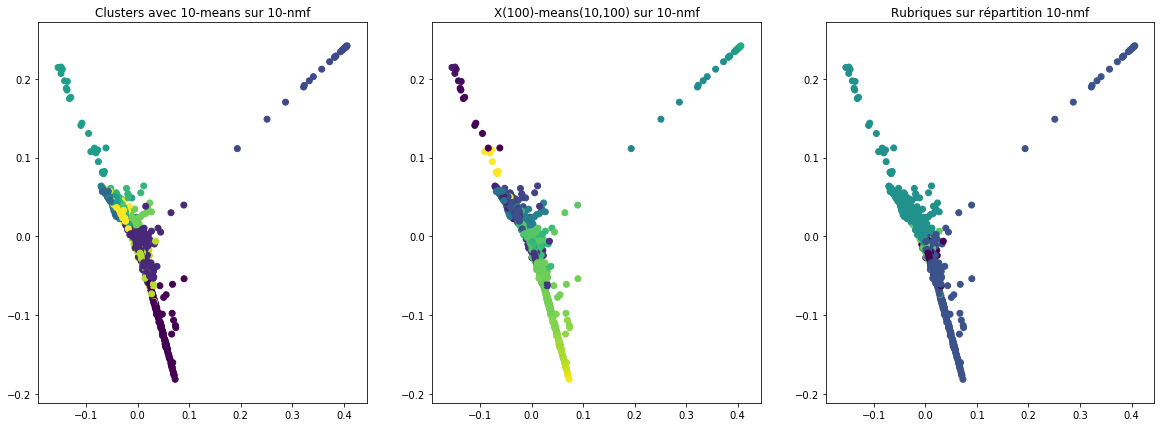

In [46]:
# Affichage ACP nmf
fig, axes = plt.subplots(1,3,figsize = (20,7))
axes[0].scatter(reduced_features_nmf[:,0], reduced_features_nmf[:,1], c=nmf_kmeans_clusters)
axes[1].scatter(reduced_features_nmf[:,0], reduced_features_nmf[:,1], c=nmf_xmeans_clusters)
axes[2].scatter(reduced_features_nmf[:,0], reduced_features_nmf[:,1], c=rubint)
axes[0].set_title("Clusters avec {}-means sur {}-nmf".format(k_kmeans_nmf,n_topics_nmf));
axes[1].set_title("X({})-means({},{}) sur {}-nmf".format(nmf_xmeans_nb_clusters,xmin_nmf,xmax_nmf,n_topics_nmf));
axes[2].set_title("Rubriques sur répartition {}-nmf".format(n_topics_nmf));

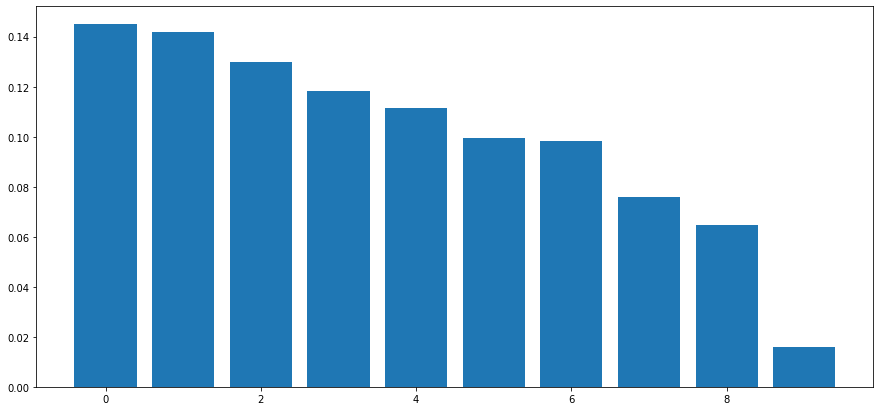

In [47]:
# Explained variance 
nmax = n_topics_nmf
pca_nmf = PCA(n_components=nmax, random_state=random_state)
pca_nmf.fit_transform(nmf_doc_vectors)
plt.figure(figsize = (15,7))
plt.bar(range(nmax),pca_nmf.explained_variance_ratio_);

In [48]:
from umap import UMAP
embedding_nmf = UMAP(n_neighbors=100, min_dist=0.5, random_state=12).fit_transform(nmf_doc_vectors)

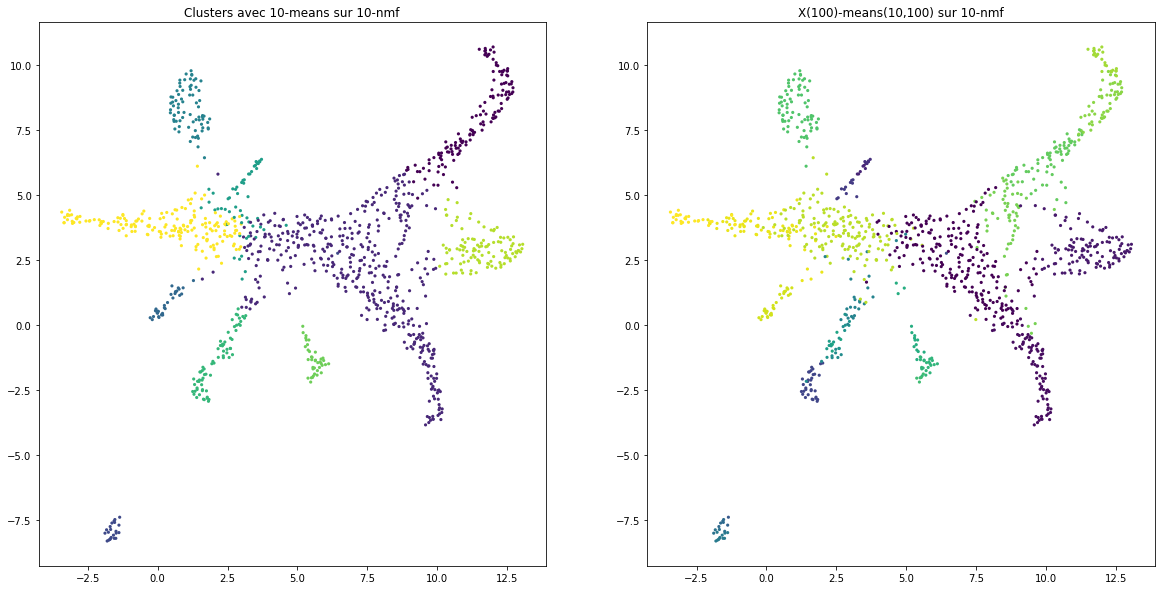

In [49]:
# Affichage umap nmf
fig,axes = plt.subplots(1,2,figsize=(20,10))
axes[0].scatter(embedding_nmf[:, 0], embedding_nmf[:, 1], 
    c = nmf_kmeans_clusters,
    s = 10, # size
    edgecolor='none')
axes[0].set_title("Clusters avec {}-means sur {}-nmf".format(k_kmeans_nmf,n_topics_nmf));
# axes[1].scatter(embedding[:, 0], embedding[:, 1], 
#     c = rubint,
#     s = 10, # size
#     edgecolor='none')
axes[1].scatter(embedding_nmf[:, 0], embedding_nmf[:, 1], 
    c = lsa_xmeans_clusters,
    s = 10, # size
    edgecolor='none')
axes[1].set_title("X({})-means({},{}) sur {}-nmf".format(nmf_xmeans_nb_clusters,xmin_nmf,xmax_nmf,n_topics_nmf));

euclidean, complete ...  ok 
euclidean, single ...  ok 
euclidean, average ...  ok 
cosine, complete ...  ok 
cosine, single ...  ok 
cosine, average ...  ok 


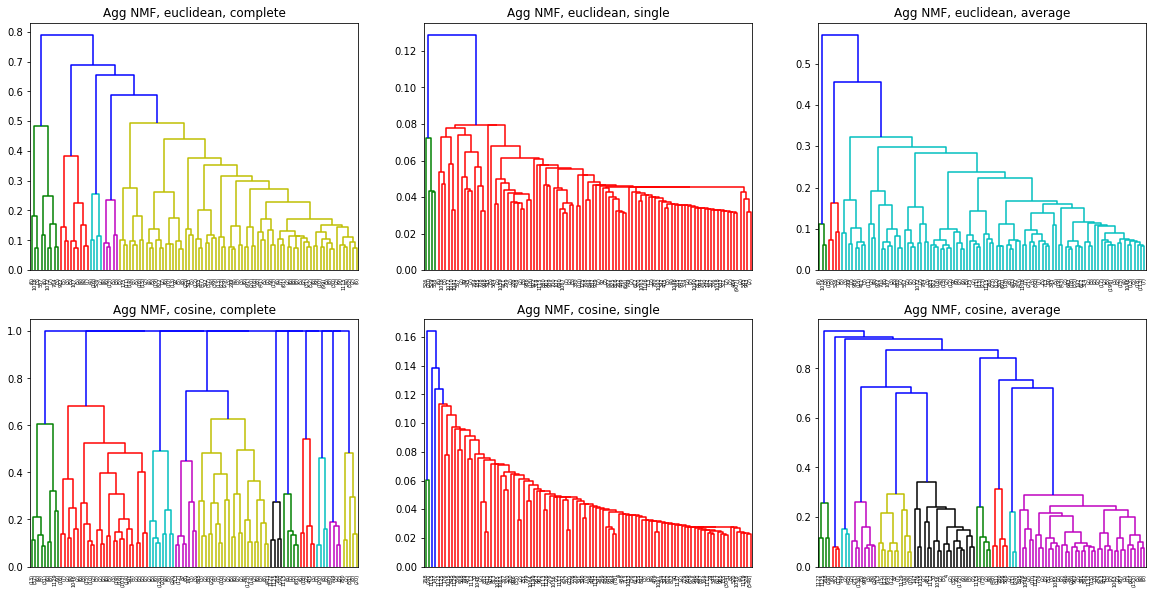

In [50]:
metrics = ['euclidean','cosine']
methods = ['complete','single','average']
fig,axes = plt.subplots(len(metrics),len(methods),figsize = (20,10))
for ic,metric in enumerate(metrics):
    for ih,method in enumerate(methods):
        print("{}, {} ...".format(metric,method),end = ' ')
        Z_nmf = linkage(nmf_doc_vectors,metric=metric,method = method);
        dendrogram(Z_nmf,p=100,truncate_mode = 'lastp',ax = axes[ic,ih])
        axes[ic,ih].set_title('Agg NMF, {}, {}'.format(metric, method))
        print(' ok ')

# D Distances entre députés

In [51]:
# Fonction calculant les distances entre lettres
# from scipy.spatial import distance_matrix
from scipy.spatial import distance

def pair_indexes(n):
    n = n - 1
    a,b = 0,1
    l = []
    while a < n :
        l.append((a,b))
        if b < n :
            b = b + 1
        else :
            a = a + 1
            b = a + 1
    return np.array(l)

In [52]:
# Import pdist
from scipy.spatial.distance import pdist, squareform

### Term Frequency

In [53]:
# Clacul avec les features du tf
vc_tf = tf.toarray()
dists_tf_euclidean = pdist(vc_tf,'euclidean')
dists_tf_cosine = pdist(vc_tf,'cosine')

Euclidean Mean = 19.64127545259109, Std = 5.281445750716063
Cosine Mean = 0.8826623739901102, Std = 0.07784873782189931


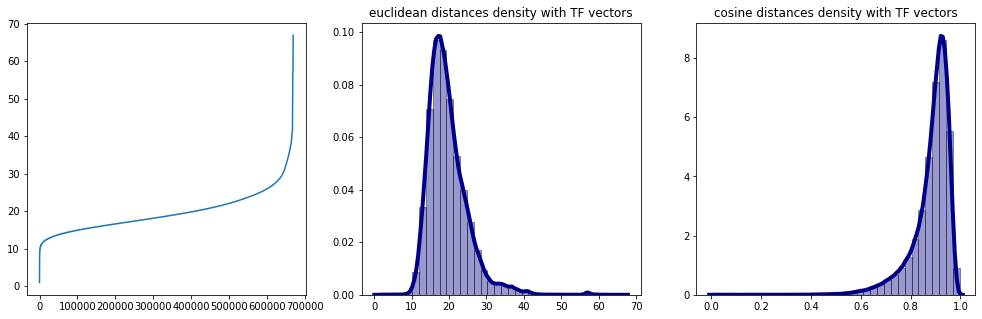

In [54]:
fig,axes = plt.subplots(1,3,figsize = (17,5))
axes[0].plot(np.sort(dists_tf_euclidean))
sns.distplot(dists_tf_euclidean, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[1])
axes[1].set_title('{} distances density with {} vectors'.format('euclidean','TF'))
sns.distplot(dists_tf_cosine, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[2])
axes[2].set_title('{} distances density with {} vectors'.format('cosine','TF'))
# print(corpus.values[(pair_indexes(len(vc_tf))[np.argsort(dists_tf)])[0]])
print("Euclidean Mean = {}, Std = {}".format(dists_tf_euclidean.mean(),dists_tf_euclidean.std()))
print("Cosine Mean = {}, Std = {}".format(dists_tf_cosine.mean(),dists_tf_cosine.std()))

### TF - IDF

In [55]:
# Clacul avec les features du tfidf
vc_tfidf = tfidf.toarray()
dists_tfidf_euclidean = pdist(vc_tfidf,'euclidean')
dists_tfidf_cosine = pdist(vc_tfidf,'cosine')

Text(0.5, 1.0, 'cosine distances density with TF-IDF vectors')

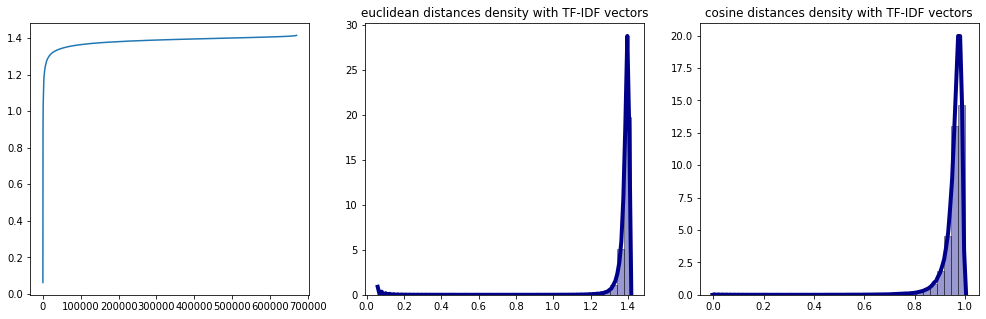

In [56]:
fig,axes = plt.subplots(1,3,figsize = (17,5))
axes[0].plot(np.sort(dists_tfidf_euclidean))
sns.distplot(dists_tfidf_euclidean, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[1])
axes[1].set_title('{} distances density with {} vectors'.format('euclidean','TF-IDF'))
sns.distplot(dists_tfidf_cosine, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[2])
axes[2].set_title('{} distances density with {} vectors'.format('cosine','TF-IDF'))

# print(corpus.values[(pair_indexes(len(vc_tfidf))[np.argsort(dists_tfidf)])[0]])
# print("Mean = {}, Std = {}".format(dists_tfidf.mean(),dists_tfidf.std()))

### PCA TF - IDF

In [57]:
# Clacul avec les reduced features du tfidf
# PCA
k_reduce = 100
reduced_tfidf = pca.fit_transform(tfidf.toarray())
pca = PCA(n_components=k_reduce, random_state=random_state)

# Calcul des distances
vc_pca = reduced_tfidf
dists_pca_euclidean, dists_pca_cosine  = pdist(vc_pca,'euclidean'), pdist(vc_pca,'cosine')

Text(0.5, 1.0, 'cosine distances density with PCA TF-IDF vectors')

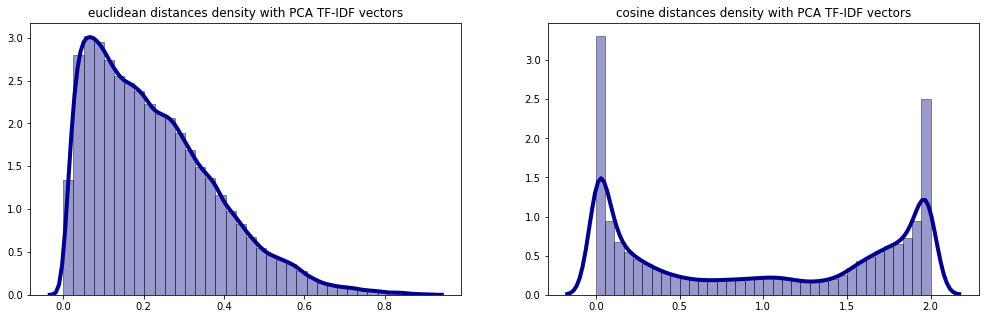

In [58]:
fig,axes = plt.subplots(1,2,figsize = (17,5))
sns.distplot(dists_pca_euclidean, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[0])
axes[0].set_title('{} distances density with {} vectors'.format('euclidean','PCA TF-IDF'))

sns.distplot(dists_pca_cosine, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[1])
axes[1].set_title('{} distances density with {} vectors'.format('cosine','PCA TF-IDF'))

# corpus.values[(pair_indexes(len(vc_pca))[np.argsort(dists_pca)])[0]]
# print("Mean = {}, Std = {}".format(dists_pca.mean(),dists_pca.std()))

### LSA

In [59]:
# Clacul avec les le LSA
vc_lsa = lsa_doc_vectors
dists_lsa_euclidean, dists_lsa_cosine =  pdist(vc_lsa,'euclidean'), pdist(vc_lsa,'cosine')

Text(0.5, 1.0, 'cosine distances density with LSA vectors')

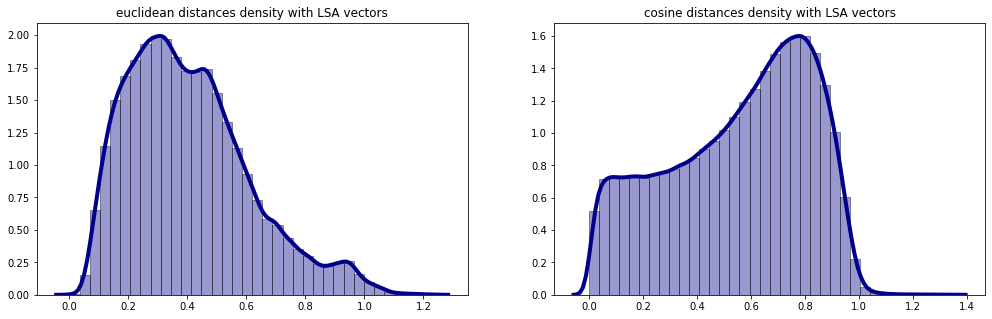

In [60]:
fig,axes = plt.subplots(1,2,figsize = (17,5))
# axes[0].plot(np.sort(dists_lsa_euclidean))
sns.distplot(dists_lsa_euclidean, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[0])
axes[0].set_title('{} distances density with {} vectors'.format('euclidean','LSA'))

sns.distplot(dists_lsa_cosine, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[1])
axes[1].set_title('{} distances density with {} vectors'.format('cosine','LSA'))

# corpus.values[(pair_indexes(len(vc_lsa))[np.argsort(dists_lsa_cosine)])[0]]
# print("Mean = {}, Std = {}".format(dists_lsa.mean(),dists_lsa.std()))

In [61]:
# Clacul avec le nmf
vc_nmf = nmf_doc_vectors
dists_nmf_euclidean, dists_nmf_cosine = pdist(vc_nmf,'euclidean'), pdist(vc_nmf,'cosine')

Text(0.5, 1.0, 'cosine distances density with NMF vectors')

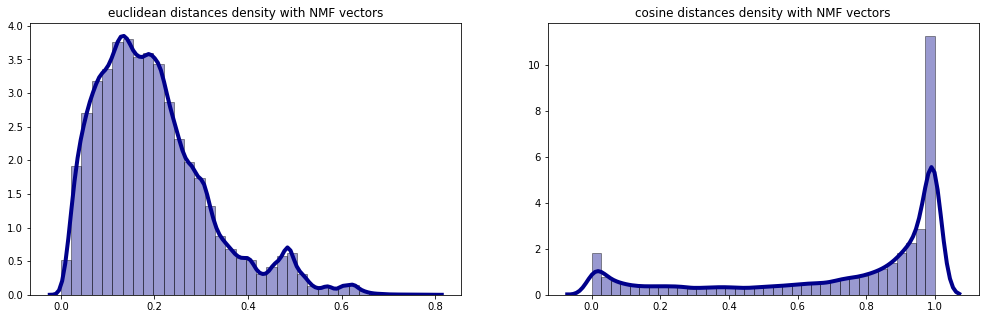

In [62]:
fig,axes = plt.subplots(1,2,figsize = (17,5))
# axes[0].plot(np.sort(dists_nmf))
sns.distplot(dists_nmf_euclidean, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[0])
axes[0].set_title('{} distances density with {} vectors'.format('euclidean','NMF'))

sns.distplot(dists_nmf_cosine, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[1])
axes[1].set_title('{} distances density with {} vectors'.format('cosine','NMF'))

# corpus.values[(pair_indexes(len(vc_nmf))[np.argsort(dists_nmf)])[0]]
# print("Mean = {}, Std = {}".format(dists_nmf.mean(),dists_nmf.std()))

### LDA

In [63]:
# Clacul avec le lda
vc_lda = lda_doc_vectors
dists_lda_euclidean, dists_lda_cosine = pdist(vc_lda,'euclidean'), pdist(vc_lda,'cosine')

Text(0.5, 1.0, 'cosine distances density with LDA vectors')

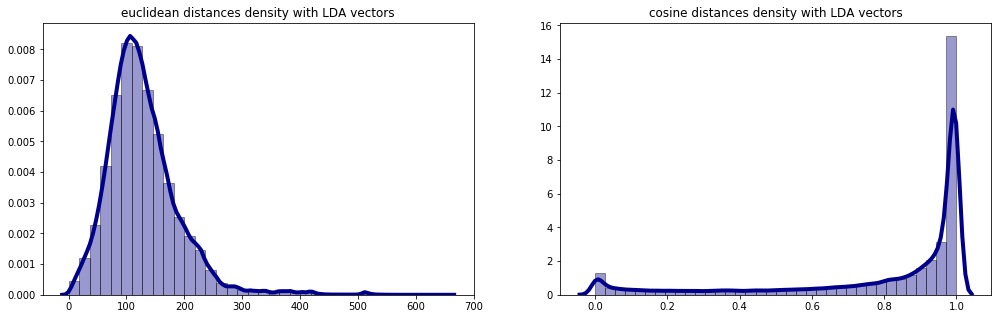

In [64]:
fig,axes = plt.subplots(1,2,figsize = (17,5))
# axes[0].plot(np.sort(dists_lda))
sns.distplot(dists_lda_euclidean, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[0])
axes[0].set_title('{} distances density with {} vectors'.format('euclidean','LDA'))

sns.distplot(dists_lda_cosine, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
            ax = axes[1])
axes[1].set_title('{} distances density with {} vectors'.format('cosine','LDA'))

# corpus.values[(pair_indexes(len(vc_lda))[np.argsort(dists_lda)])[0]]
# print("Mean = {}, Std = {}".format(dists_lda.mean(),dists_lda.std()))

# E. Tests avec des textes choisis

In [65]:
# Choix des documents
dfhi = dfh.reset_index(drop=True)
l_lyme = dfhi[dfhi.titre.str.contains('lyme')&dfhi.titre.str.contains('lutte')&dfhi.titre.str.contains('maladie')].head(3)
l_front = dfhi[dfhi.titre.str.contains('frontalier')&dfhi.titre.str.contains('travailleur')]
l_ha = dfhi.loc[[4]]
lettres_choisies= pd.concat([l_lyme,l_front,l_ha])

### TF

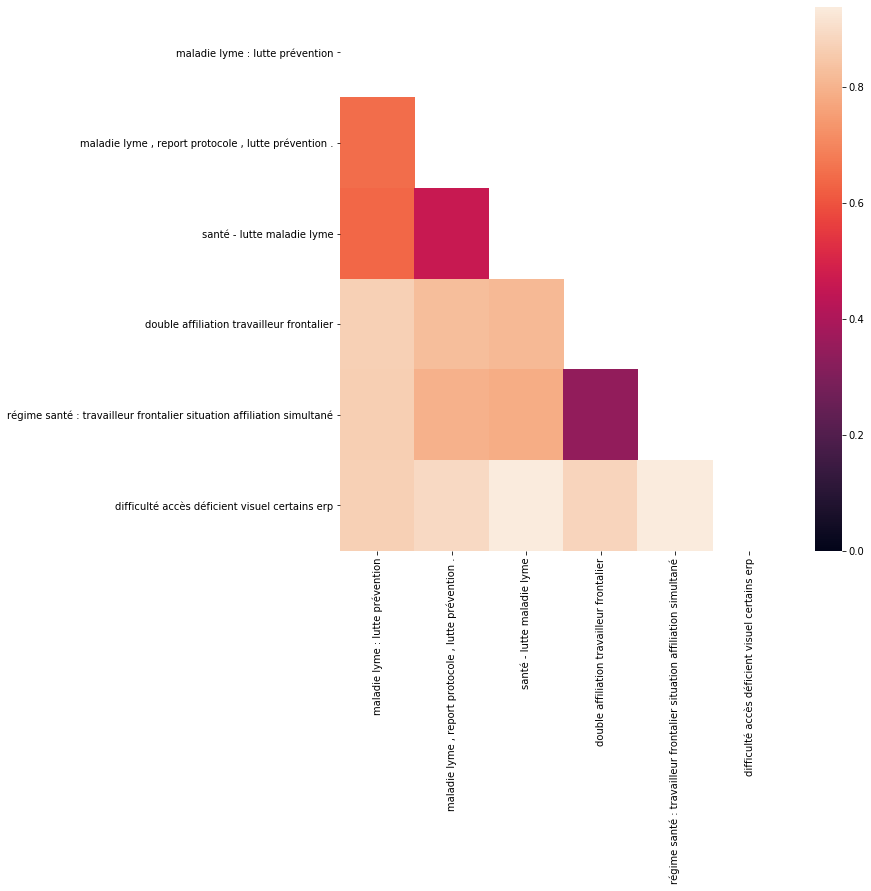

In [66]:
# Brut tf
docs_choisis_tf = tf.toarray()[lettres_choisies.index]
matrix_choisie_tf = squareform(pdist(docs_choisis_tf,'cosine'))

# Affichage
import seaborn as sns
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(matrix_choisie_tf) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(matrix_choisie_tf,ax = ax, xticklabels=lettres_choisies.titre, yticklabels=lettres_choisies.titre,mask=mask);

### TF -IDF

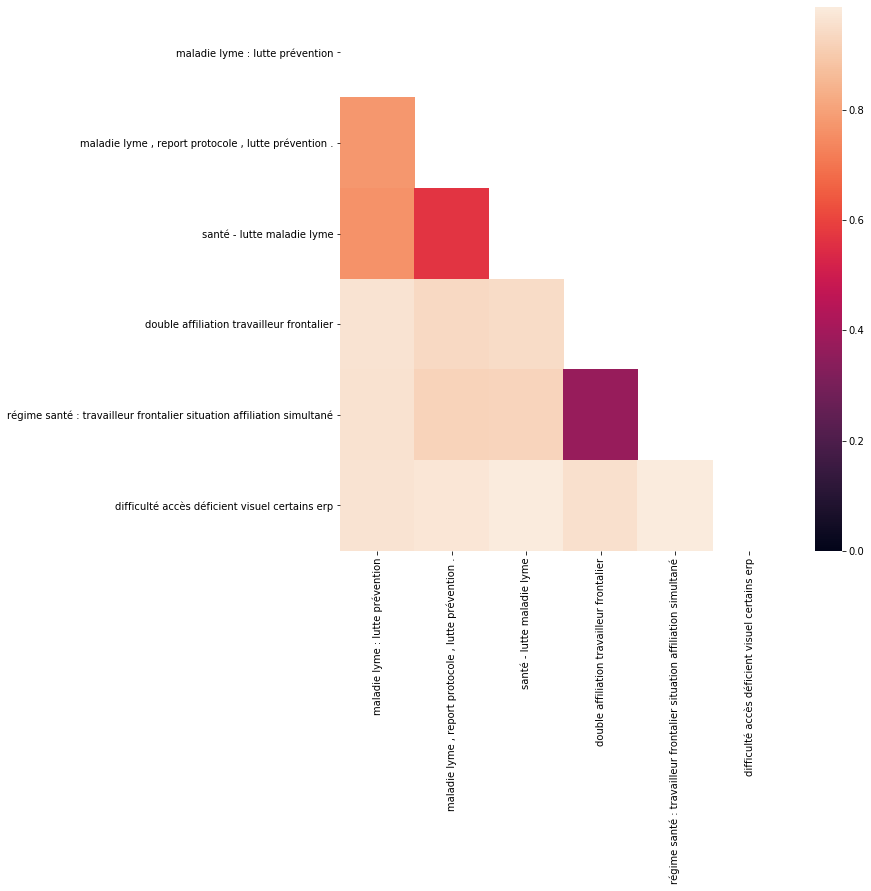

In [67]:
# Brut tfidf
docs_choisis_tfidf = tfidf.toarray()[lettres_choisies.index]
matrix_choisie_tfidf = squareform(pdist(docs_choisis_tfidf,'cosine'))

# Affichage
import seaborn as sns
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(matrix_choisie_tfidf) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(matrix_choisie_tfidf,ax = ax, xticklabels=lettres_choisies.titre, yticklabels=lettres_choisies.titre,mask=mask);

### PCA TF - IDF

### LSA

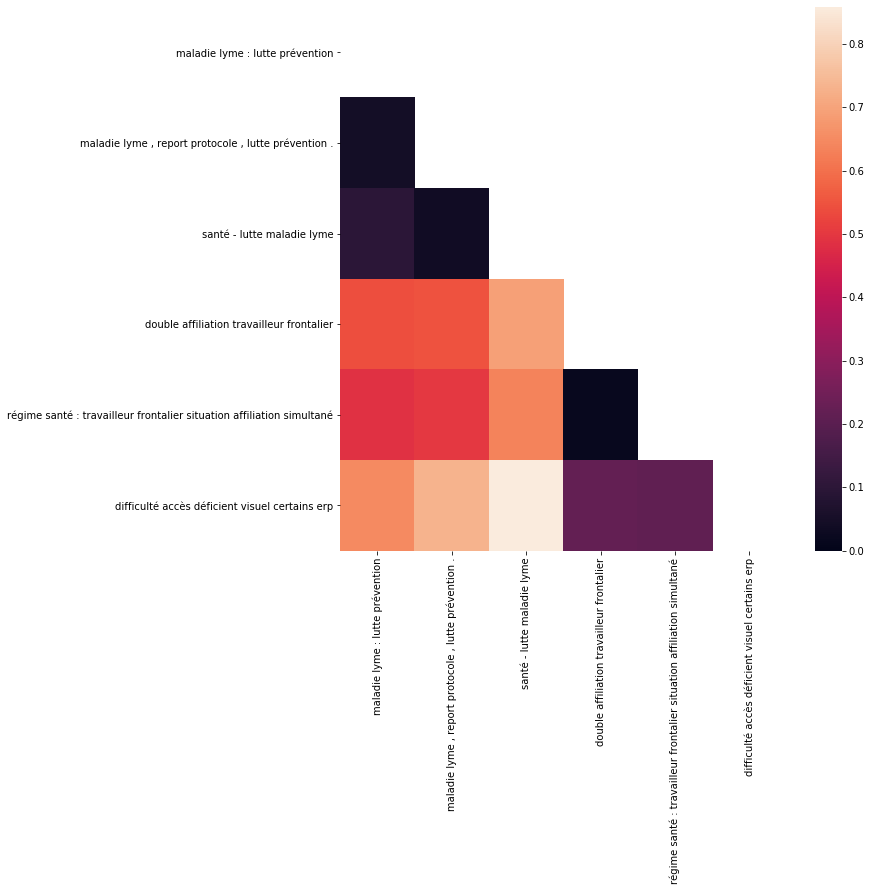

In [69]:
# LSA
docs_choisis_lsa = lsa_doc_vectors[lettres_choisies.index]
matrix_choisie_lsa = squareform(pdist(docs_choisis_lsa,'cosine'))

# Affichage
import seaborn as sns
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(matrix_choisie_lsa) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(matrix_choisie_lsa,ax = ax, xticklabels=lettres_choisies.titre, yticklabels=lettres_choisies.titre,mask=mask);

### LDA

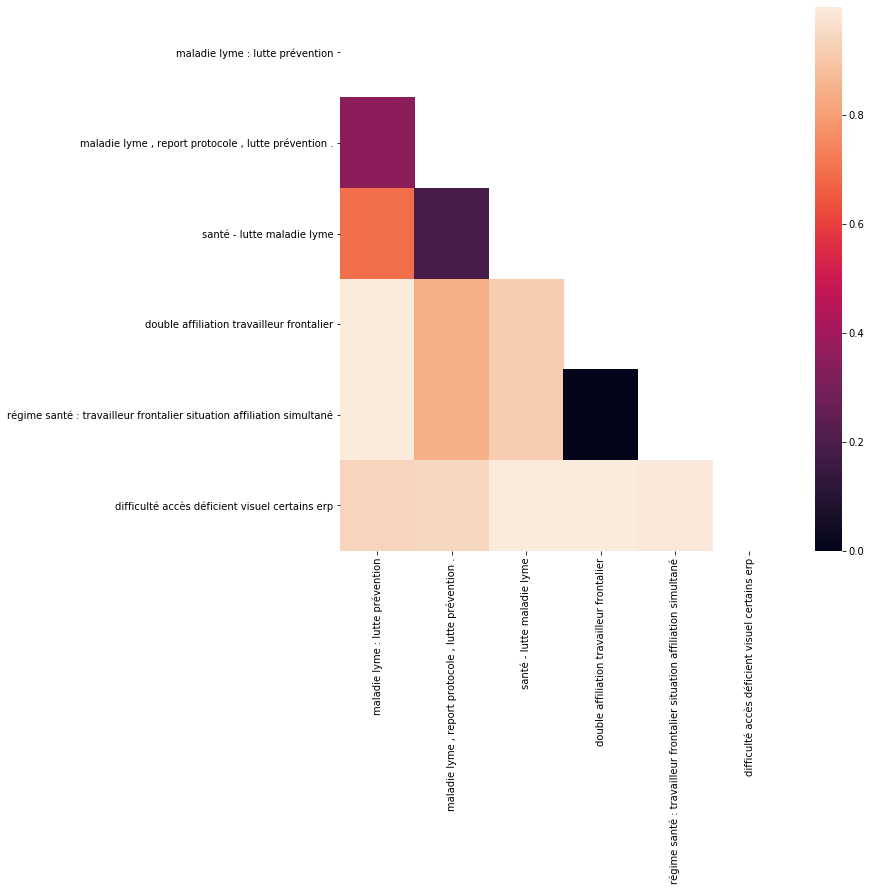

In [70]:
# LDA
docs_choisis_lda = lda_doc_vectors[lettres_choisies.index]
matrix_choisie_lda = squareform(pdist(docs_choisis_lda,'cosine'))

# Affichage
import seaborn as sns
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(matrix_choisie_lda) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(matrix_choisie_lda,ax = ax, xticklabels=lettres_choisies.titre, yticklabels=lettres_choisies.titre,mask=mask);

## NMF

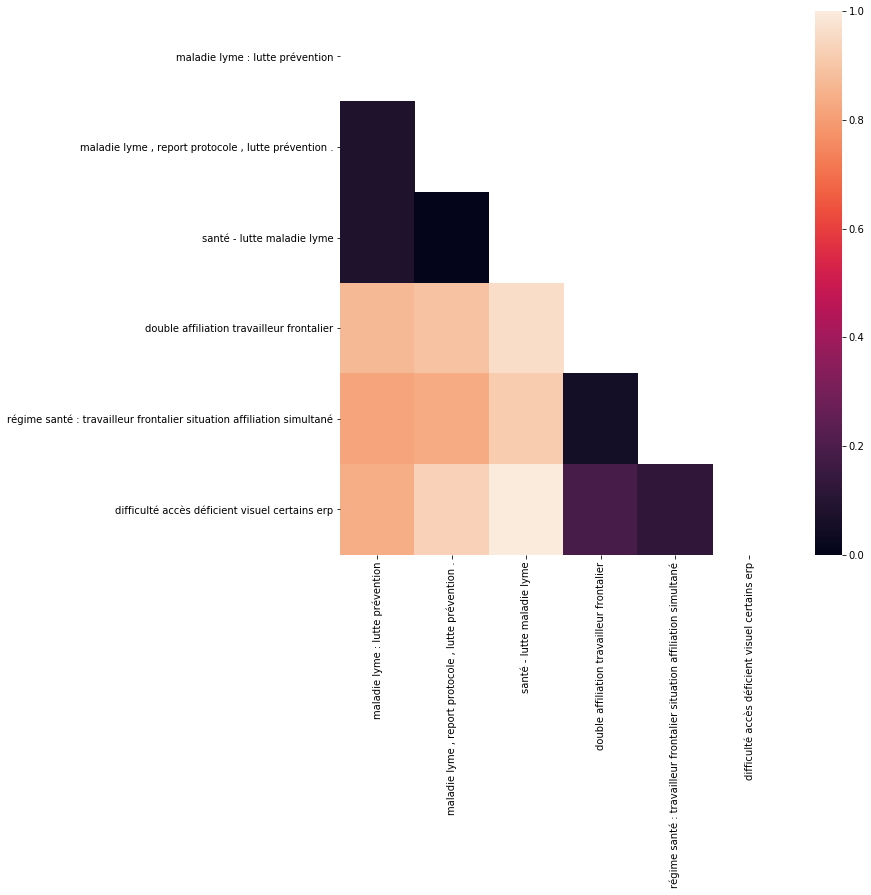

In [71]:
# nmf
docs_choisis_nmf = nmf_doc_vectors[lettres_choisies.index]
matrix_choisie_nmf = squareform(pdist(docs_choisis_nmf,'cosine'))

# Affichage
import seaborn as sns
f, ax = plt.subplots(figsize = (10,10))
mask = np.zeros_like(matrix_choisie_nmf) # Masquer le triangle sup
mask[np.triu_indices_from(mask)] = True 
sns.heatmap(matrix_choisie_nmf,ax = ax, xticklabels=lettres_choisies.titre, yticklabels=lettres_choisies.titre,mask=mask);

## F. Trouver les amis d'une lettre

In [72]:
matrix = squareform(dists_lda_cosine)

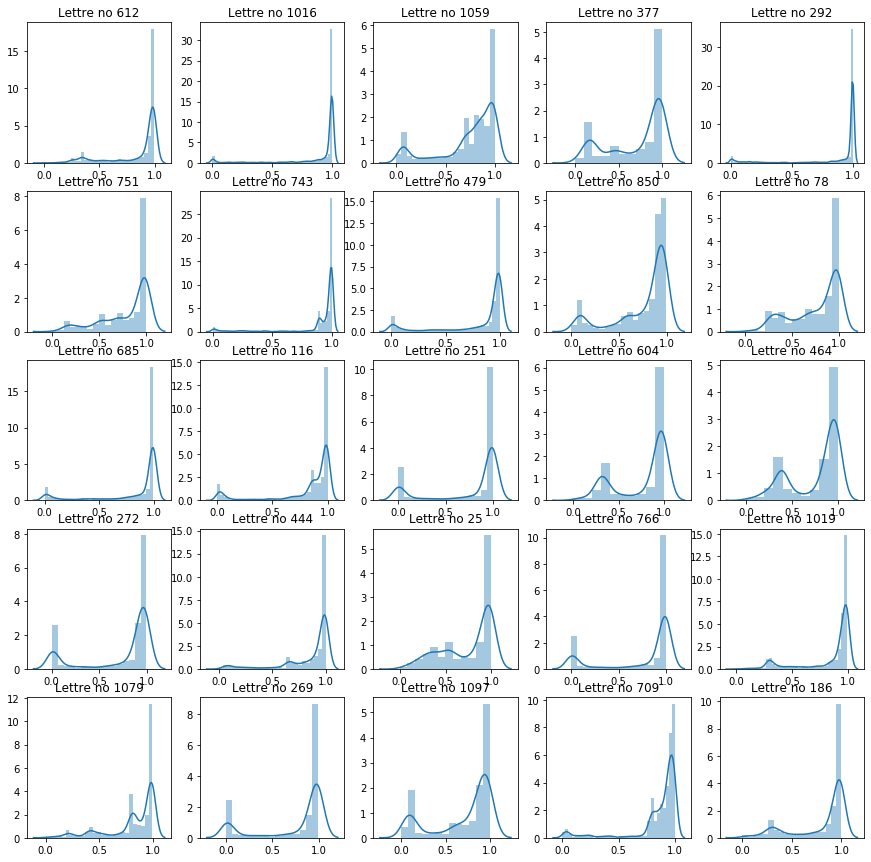

In [73]:
r = 5
c = 5
trucs = sample(range(len(corpus)),r*c)
fig,axes = plt.subplots(r,c,figsize=(15,15))
for i in range(c):
    for j in range(r):
        sns.distplot(matrix[trucs[i*c+j]],ax = axes[i,j])
        axes[i,j].set_title('Lettre no {}'.format(trucs[i*c+j]))

In [74]:
# Choisir un numéro
num = 536
indices = matrix[num].argsort()
titres = dfh.reset_index(drop = True).titre
print('Lettre :', titres[num])
print('Proches :',[titres[i] for i in indices[:25]])
print('Éloignées :',[titres[i] for i in indices[-3:]])

Lettre : déficit école national administration
Proches : ['déficit école national administration', 'école national administration : gestion denier public', 'situation financier ena', 'ant - dématérialisation - dysfonctionnement', 'recouvrement créance école national administration', 'déficit compte ena', 'bilan dématérialisation permettre conduire', 'gestion compte ena', 'ena - finance public - déficit', 'compte déficitaire école national administration', 'déficit ena', 'mauvais gestion compte école national administration', 'mauvais gestion école national administration', 'ena devoir repenser gestion', 'déficit ena', 'déficit ena', 'ena - déficit - gestion', 'redressement compte ena', 'gestion financier école national administration', 'ant - carte gris véhicule communal', 'dématérialisation demande titre', 'dysfonctionnement plateforme internet demande carte gris', 'dysfonctionnement lier dématérialisation demande carte gris', 'déficit école national administration ( ena )', 'délai in

/home/achile/Programmes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


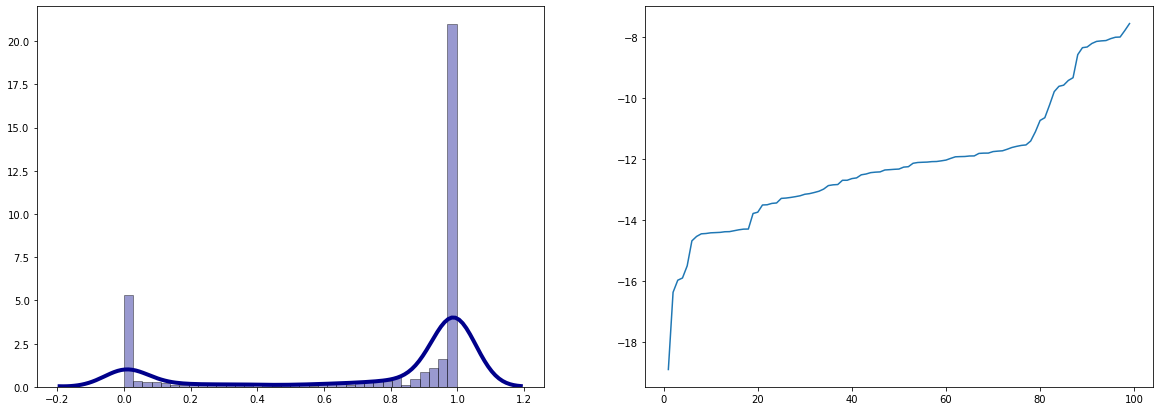

In [75]:
fig, axes = plt.subplots(1,2,figsize = (20,7))
sns.distplot(matrix[536], hist=True, kde=True, 
     bins=int(180/5), color = 'darkblue', 
     hist_kws={'edgecolor':'black'},
     kde_kws={'linewidth': 4},ax = axes[0])
axes[1].plot(np.log(np.sort(matrix[536])[:100]))

# F. Tests d'évalutation des clustering

In [76]:
# Choix des données
doc_vec = lda_doc_vectors
doc_vec.shape

(1158, 10)

## F.2 Pour trouver le meilleur k
Voir https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

In [77]:
# Exécution des k-means
possible_k = range(1,36,1)
criterions = pd.DataFrame(columns = ['inertie','calinski','bouldin'])
parts = np.empty((len(possible_k),len(doc_vec)))
inerties = np.empty((len(possible_k,)))
calinski = np.empty((len(possible_k,)))
bouldin = np.empty((len(possible_k,)))
for i,k in enumerate(possible_k):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(doc_vec);
    kmeans_clusters = kmeans.predict(doc_vec)
    parts[i] = kmeans_clusters
    criterions.loc[k,'inertie'] = kmeans.inertia_
    if k > 1:
        criterions.loc[k,'calinski'] = calinski_harabasz_score(doc_vec,kmeans_clusters)
        criterions.loc[k,'bouldin'] = davies_bouldin_score(doc_vec,kmeans_clusters)

### F.2.2 Critères

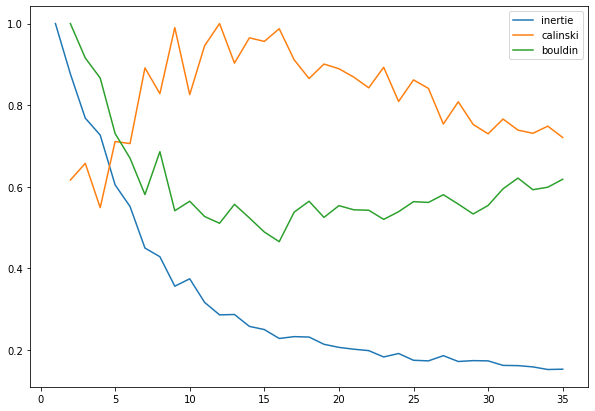

In [78]:
(criterions/criterions.max()).plot(figsize = (10,7))

## F.3 Comparer deux partitions 

In [79]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(parts[3],parts[4]),adjusted_rand_score(parts[10],parts[15])

(0.31546022679558433, 0.6413695107314223)

In [80]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

jaccard_similarity(parts[3],parts[4]),jaccard_similarity(parts[10],parts[15])

(0.0017301038062283738, 0.004772234273318872)

## F.3.2 Matrice de comparaison des partitions

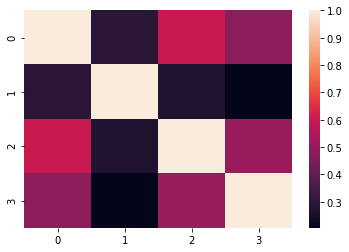

In [81]:
from sklearn.metrics import pairwise_distances
partitions = np.array([lsa_kmeans_clusters,lda_kmeans_clusters, nmf_kmeans_clusters, tfidf_kmeans_clusters])
matrix_ARI = pairwise_distances(partitions,metric = adjusted_rand_score)
sns.heatmap(matrix_ARI)#, xticklabels=lettres_choisies.titre, yticklabels=lettres_choisies.titre,mask=mask);

## G Spectral clustering

In [82]:
from sklearn.cluster import SpectralClustering

In [83]:
spec_matrix = squareform(dists_nmf_cosine)
spec_cluster = SpectralClustering(n_clusters=15, assign_labels="discretize", random_state=0,affinity='precomputed').fit(spec_matrix)
spec_cluster.labels_

array([12,  5,  0, ...,  6,  0,  5])

In [84]:
spec_cluster.labels_

array([12,  5,  0, ...,  6,  0,  5])

In [85]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(nmf_doc_vectors)

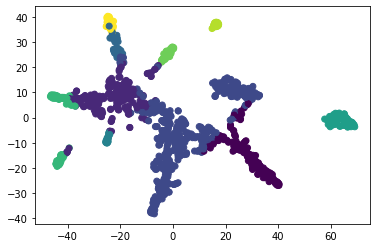

In [86]:
plt.scatter(X_embedded[:,0],X_embedded[:,1],c =kmeans_lsa.predict(lsa_doc_vectors))

# H Prototypes

In [87]:
# Prendre un cluster :
